# Text Summarization and Topic Models
* Text Summarization and Information Extraction
* Important Concepts
* Keyphrase Extractions
    1. Collocations
    2. Weighted Tag-Based Phrase Extraction
* Topic Modeling on Research Papers
    1. The Main Objective
    2. Data Retrieval
    3. Load and View Dataset
    4. Basic Text Wrangling
* Topic Models with Gensim
    1. Text Representation with Feature Engineering
    2. Latent Semantic Indexing
    3. Implementing LSI Topic Models from Scratch
    4. Latent Dirichlet Allocation
    5. LDA Models with MALLET
    6. LDA Tuning: Finding the Optimal Number of Topics
    7. Interpreting Topic Model Results
    8. Predicting Topics for New Research Papers
* Topic Models with Scikit-Learn
    1. Text Representation with Feature Engineering
    2. Latent Semantic Indexing
    3. Latent Dirichlet Allocation
    4. Non-Negative Matrix Factorization
    5. Predicting Topics for New Research Papers
    6. Visualizing Topic Models
* Automated Document Summarization
    1. Text Wrangling
    2. Text Representation with Feature Engineering
    3. Latent Semantic Analysis
    4. TextRank

In [1]:
## Loading packages

# if spacy doesn't run
#!pip install spacy
#!python -m spacy download en_core_web_sm

# if nltk error
#import nltk
#nltk.download('all')

# import gensim
#!pip install gensim

In [2]:
# Azure ML path
path_to_users = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/bellepracticevm/code/Users'
path_to_nlp = path_to_users + '/LearningCode/NLP_Learning'

## Important Concepts

In [3]:
# extract top k singular values and return corresponding U, S, & V matrices
from scipy.sparse.linalg import svds

def low_rank_svd(matrix, singular_count=2):
    u,s,vt = svds(matrix, k=singular_count)
    return u,s,vt

## Keyphrase Extraction

In [4]:
## Collocations
from nltk.corpus import gutenberg
import text_normalizer as tn
import nltk
from operator import itemgetter

# load corpus
alice = gutenberg.sents(fileids='carroll-alice.txt')
alice = [' '.join(ts) for ts in alice]
norm_alice = list(filter(None,
                         tn.normalize_corpus(alice, text_lemmatization=False)))

# print and compare first line
print(alice[0], '\n', norm_alice[0])

[ Alice ' s Adventures in Wonderland by Lewis Carroll 1865 ] 
 alice adventures wonderland lewis carroll


In [5]:
def compute_ngrams(sequence, n):
    return list(
            zip(*(sequence[index:]
                  for index in range(n))))

# test function
compute_ngrams([1,2,3,4], 2) # bi-grams
compute_ngrams([1,2,3,4], 3) # tri-grams

[(1, 2, 3), (2, 3, 4)]

In [6]:
# function to flatten corpus into one big string of text
def flatten_corpus(corpus):
    return ' '.join([document.strip()
                    for document in corpus])

# get top n-grams for corpus of text
def get_top_ngrams(corpus, ngram_val=1, limit=5):
    corpus = flatten_corpus(corpus)
    tokens = nltk.word_tokenize(corpus)
    
    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(),
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq)
                     for text, freq in sorted_ngrams]
    return sorted_ngrams

In [7]:
# top 10 bigrams
get_top_ngrams(corpus=norm_alice, ngram_val=2, limit=10)

[('said alice', 123),
 ('mock turtle', 56),
 ('march hare', 31),
 ('said king', 29),
 ('thought alice', 26),
 ('white rabbit', 22),
 ('said hatter', 22),
 ('said mock', 20),
 ('said caterpillar', 18),
 ('said gryphon', 18)]

In [8]:
# top 10 trigrams
get_top_ngrams(corpus=norm_alice, ngram_val=3, limit=10)

[('said mock turtle', 20),
 ('said march hare', 10),
 ('poor little thing', 6),
 ('little golden key', 5),
 ('certainly said alice', 5),
 ('white kid gloves', 5),
 ('march hare said', 5),
 ('mock turtle said', 5),
 ('know said alice', 4),
 ('might well say', 4)]

In [9]:
# use NLTK's collocation finders
# bigrams
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures

finder = BigramCollocationFinder.from_documents([item.split() for item in norm_alice])
finder

In [10]:
bigram_measures = BigramAssocMeasures()

# raw frequencies
finder.nbest(bigram_measures.raw_freq, 10)

[('said', 'alice'),
 ('mock', 'turtle'),
 ('march', 'hare'),
 ('said', 'king'),
 ('thought', 'alice'),
 ('said', 'hatter'),
 ('white', 'rabbit'),
 ('said', 'mock'),
 ('said', 'caterpillar'),
 ('said', 'gryphon')]

In [11]:
# pointwise mutual information
finder.nbest(bigram_measures.pmi, 10)

[('abide', 'figures'),
 ('acceptance', 'elegant'),
 ('accounting', 'tastes'),
 ('accustomed', 'usurpation'),
 ('act', 'crawling'),
 ('adjourn', 'immediate'),
 ('adoption', 'energetic'),
 ('affair', 'trusts'),
 ('agony', 'terror'),
 ('alarmed', 'proposal')]

In [12]:
# trigrams
from nltk.collocations import TrigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures

finder = TrigramCollocationFinder.from_documents([item.split() for item in norm_alice])

trigram_measures = TrigramAssocMeasures()

In [13]:
# raw frequencies
finder.nbest(trigram_measures.raw_freq, 10)

[('said', 'mock', 'turtle'),
 ('said', 'march', 'hare'),
 ('poor', 'little', 'thing'),
 ('little', 'golden', 'key'),
 ('march', 'hare', 'said'),
 ('mock', 'turtle', 'said'),
 ('white', 'kid', 'gloves'),
 ('beau', 'ootiful', 'soo'),
 ('certainly', 'said', 'alice'),
 ('might', 'well', 'say')]

In [14]:
# pointwise mutual information
finder.nbest(trigram_measures.pmi, 10)

[('accustomed', 'usurpation', 'conquest'),
 ('adjourn', 'immediate', 'adoption'),
 ('adoption', 'energetic', 'remedies'),
 ('ancient', 'modern', 'seaography'),
 ('apple', 'roast', 'turkey'),
 ('arithmetic', 'ambition', 'distraction'),
 ('brother', 'latin', 'grammar'),
 ('canvas', 'bag', 'tied'),
 ('cherry', 'tart', 'custard'),
 ('circle', 'exact', 'shape')]

In [15]:
## Weighted Tag-Based Phrase Extraction
data = open('data/elephants.txt', 'r+').readlines()
sentences = nltk.sent_tokenize(data[0])
len(sentences)

29

In [16]:
# viewing the first three lines
sentences[:3]

['Elephants are large mammals of the family Elephantidae and the order Proboscidea.',
 'Three species are currently recognised: the African bush elephant (Loxodonta africana), the African forest elephant (L. cyclotis), and the Asian elephant (Elephas maximus).',
 'Elephants are scattered throughout sub-Saharan Africa, South Asia, and Southeast Asia.']

In [17]:
norm_sentences = tn.normalize_corpus(sentences, text_lower_case=False, text_stemming=False,
                                     text_lemmatization=False, stopword_removal=False)
norm_sentences[:3]

['Elephants are large mammals of the family Elephantidae and the order Proboscidea',
 'Three species are currently recognised the African bush elephant Loxodonta africana the African forest elephant L cyclotis and the Asian elephant Elephas maximus',
 'Elephants are scattered throughout subSaharan Africa South Asia and Southeast Asia']

In [18]:
import itertools
stopwords = nltk.corpus.stopwords.words('english')

def get_chunks(sentences, grammar=r'NP: {<DT>? <JJ>* <NN.*>+}', stopword_list=stopwords):
    all_chunks = []
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    
    for sentence in sentences:
        tagged_sents = [nltk.pos_tag(nltk.word_tokenize(sentence))]
        chunks = [chunker.parse(tagged_sent)
                     for tagged_sent in tagged_sents]
        wtc_sents = [nltk.chunk.tree2conlltags(chunk)
                        for chunk in chunks]
        flattened_chunks = list(itertools.chain.from_iterable(wtc_sent for wtc_sent in wtc_sents))
        valid_chunks_tagged = [(status, [wtc for wtc in chunk])
                                    for status, chunk in itertools.groupby(flattened_chunks,
                                                      lambda word_pos_chunk: 
                                                      word_pos_chunk[2] != 'O')]
        valid_chunks = [' '.join(word.lower()
                                 for word, tag, chunk in wtc_group
                                     if word.lower() not in stopword_list)
                                        for status, wtc_group in valid_chunks_tagged if status]
        all_chunks.append(valid_chunks)
    return all_chunks

In [19]:
chunks = get_chunks(norm_sentences)
chunks

[['elephants', 'large mammals', 'family elephantidae', 'order proboscidea'],
 ['species',
  'african bush elephant loxodonta',
  'african forest elephant l cyclotis',
  'asian elephant elephas maximus'],
 ['elephants', 'subsaharan africa south asia', 'southeast asia'],
 ['elephantidae',
  'family',
  'order proboscidea',
  'extinct members',
  'order',
  'deinotheres gomphotheres mammoths',
  'mastodons'],
 ['elephants',
  'several distinctive features',
  'long trunk',
  'proboscis',
  'many purposes',
  'water',
  'grasping objects'],
 ['incisors', 'tusks', 'weapons', 'tools', 'objects'],
 ['elephants', 'flaps', 'body temperature'],
 ['pillarlike legs', 'great weight'],
 ['african elephants',
  'ears',
  'backs',
  'asian elephants',
  'ears',
  'convex',
  'level backs'],
 ['elephants', 'different habitats', 'savannahs forests deserts', 'marshes'],
 ['water'],
 ['keystone species', 'impact', 'environments'],
 ['animals',
  'distance',
  'elephants',
  'predators',
  'lions tigers hy

In [20]:
from gensim import corpora, models

def get_tfidf_weighted_keyphrases(sentences, grammar=r'NP: {<DT>? <JJ>* <NN.*>+}', top_n=10):
    valid_chunks = get_chunks(sentences, grammar=grammar)
    
    dictionary = corpora.Dictionary(valid_chunks)
    corpus = [dictionary.doc2bow(chunk) for chunk in valid_chunks]
    
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    weighted_phrases = {dictionary.get(idx): value for doc in corpus_tfidf for idx, value in doc}
    weighted_phrases = sorted(weighted_phrases.items(),
                              key=itemgetter(1), reverse=True)
    weighted_phrases = [(term, round(wt,3)) for term, wt in weighted_phrases]
    
    return weighted_phrases[:top_n]

In [21]:
# top 30 tf-idf weighted keyphrases
get_tfidf_weighted_keyphrases(sentences=norm_sentences, top_n=30)

[('water', 1.0),
 ('asia', 0.807),
 ('wild', 0.764),
 ('great weight', 0.707),
 ('pillarlike legs', 0.707),
 ('southeast asia', 0.693),
 ('subsaharan africa south asia', 0.693),
 ('body temperature', 0.693),
 ('flaps', 0.693),
 ('fissionfusion society', 0.693),
 ('multiple family groups', 0.693),
 ('art folklore religion literature', 0.693),
 ('popular culture', 0.693),
 ('ears', 0.681),
 ('males', 0.653),
 ('males bulls', 0.653),
 ('family elephantidae', 0.607),
 ('large mammals', 0.607),
 ('years', 0.607),
 ('environments', 0.577),
 ('impact', 0.577),
 ('keystone species', 0.577),
 ('cetaceans', 0.577),
 ('elephant intelligence', 0.577),
 ('primates', 0.577),
 ('dead individuals', 0.577),
 ('kind', 0.577),
 ('selfawareness', 0.577),
 ('different habitats', 0.57),
 ('marshes', 0.57)]

In [22]:
from gensim.summarization import keywords

key_words = keywords(data[0], ratio=1.0, scores=True, lemmatize=True)
[(item, round(score,3)) for item, score in key_words][:25]

[('african bush elephant', 0.261),
 ('including', 0.141),
 ('family', 0.137),
 ('cow', 0.124),
 ('forests', 0.108),
 ('female', 0.103),
 ('asia', 0.102),
 ('objects', 0.098),
 ('sight', 0.098),
 ('ivory', 0.098),
 ('tigers', 0.098),
 ('males', 0.088),
 ('religion', 0.087),
 ('folklore', 0.087),
 ('known', 0.087),
 ('larger ears', 0.085),
 ('water', 0.075),
 ('highly recognisable', 0.075),
 ('breathing lifting', 0.074),
 ('flaps', 0.073),
 ('africa', 0.072),
 ('gomphotheres', 0.072),
 ('animals tend', 0.071),
 ('success', 0.071),
 ('south', 0.07)]

## Topic Modeling on Research Papers

In [23]:
## Data Retrieval
#!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz

In [24]:
# extract dataset
#!tar -xzf nips12raw_str602.tgz

In [25]:
import os
import numpy as np
import pandas as pd

DATA_PATH = path_to_users + '/nipstxt/'
print(os.listdir(DATA_PATH))

['idx', 'MATLAB_NOTES', 'nips00', 'nips01', 'nips02', 'nips03', 'nips04', 'nips05', 'nips06', 'nips07', 'nips08', 'nips09', 'nips10', 'nips11', 'nips12', 'orig', 'RAW_DATA_NOTES', 'README_yann']


In [26]:
## Load and View Dataset
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# read all texts into a list
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

1740

In [27]:
print(papers[0][:1000])

1 
CONNECTIVITY VERSUS ENTROPY 
Yaser S. Abu-Mostafa 
California Institute of Technology 
Pasadena, CA 91125 
ABSTRACT 
How does the connectivity of a neural network (number of synapses per 
neuron) relate to the complexity of the problems it can handle (measured by 
the entropy)? Switching theory would suggest no relation at all, since all Boolean 
functions can be implemented using a circuit with very low connectivity (e.g., 
using two-input NAND gates). However, for a network that learns a problem 
from examples using a local learning rule, we prove that the entropy of the 
problem becomes a lower bound for the connectivity of the network. 
INTRODUCTION 
The most distinguishing feature of neural networks is their ability to spon- 
taneously learn the desired function from 'training' samples, i.e., their ability 
to program themselves. Clearly, a given neural network cannot just learn any 
function, there must be some restrictions on which networks can learn which 
functions. One obv

In [28]:
%%time
## Basic Text Wrangling
import nltk

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
        
    return norm_papers

norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740
CPU times: user 25.6 s, sys: 0 ns, total: 25.6 s
Wall time: 25.7 s


In [29]:
# viewing a processed paper
print(norm_papers[0][:50])

['connectivity', 'versus', 'entropy', 'yaser', 'abu', 'mostafa', 'california', 'institute', 'technology', 'pasadena', 'ca', 'abstract', 'doe', 'connectivity', 'neural', 'network', 'number', 'synapsis', 'per', 'neuron', 'relate', 'complexity', 'problem', 'handle', 'measured', 'entropy', 'switching', 'theory', 'would', 'suggest', 'relation', 'since', 'boolean', 'function', 'implemented', 'using', 'circuit', 'low', 'connectivity', 'using', 'two', 'input', 'nand', 'gate', 'however', 'network', 'learns', 'problem', 'example', 'using']


## Topic Models with Gensim

In [30]:
## Text Representation with Feature Engineering
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, 
                               threshold=20, delimiter=b'_') # higher threshold fewer phrases
bigram_model = gensim.models.phrases.Phraser(bigram)

# sample demonstration
print(bigram_model[norm_papers[0]][:50])

['connectivity', 'versus', 'entropy', 'yaser', 'abu_mostafa', 'california_institute', 'technology_pasadena', 'ca_abstract', 'doe', 'connectivity', 'neural_network', 'number', 'synapsis', 'per', 'neuron', 'relate', 'complexity', 'problem', 'handle', 'measured', 'entropy', 'switching', 'theory', 'would', 'suggest', 'relation', 'since', 'boolean_function', 'implemented', 'using', 'circuit', 'low', 'connectivity', 'using', 'two', 'input', 'nand', 'gate', 'however', 'network', 'learns', 'problem', 'example', 'using', 'local', 'learning', 'rule', 'prove', 'entropy', 'problem']


In [31]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# create a dictionary representation of the documents
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size', len(dictionary))

Sample word to number mappings: [(0, '0a'), (1, '2h'), (2, '2h2'), (3, '2he'), (4, '2n'), (5, '__c'), (6, '_c'), (7, '_k'), (8, 'a2'), (9, 'ability'), (10, 'abu_mostafa'), (11, 'access'), (12, 'accommodate'), (13, 'according'), (14, 'accumulated')]
Total Vocabulary Size 78892


In [32]:
# filer out words that occur less than 20 documents, or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


In [33]:
# transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(3, 1), (12, 3), (14, 1), (15, 1), (16, 1), (17, 16), (20, 1), (24, 1), (26, 1), (31, 3), (35, 1), (36, 1), (40, 3), (41, 5), (42, 1), (48, 1), (53, 3), (55, 1), (56, 2), (58, 1), (60, 3), (63, 5), (64, 4), (65, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 3), (82, 1), (83, 4), (84, 1), (85, 1), (86, 2), (94, 1), (96, 2), (97, 3), (106, 1), (110, 1), (119, 2), (120, 4), (121, 2), (124, 2), (127, 1), (128, 1), (132, 1), (133, 1), (135, 6), (136, 1), (144, 1)]


In [34]:
# viewing actual terms and their counts
print([(dictionary[idx], freq) for idx, freq in bow_corpus[1][:50]])

[('ability', 1), ('aip', 3), ('although', 1), ('american_institute', 1), ('amount', 1), ('analog', 16), ('appears', 1), ('architecture', 1), ('aspect', 1), ('available', 3), ('become', 1), ('becomes', 1), ('binary', 3), ('biological', 5), ('bit', 1), ('cannot', 1), ('circuit', 3), ('collective', 1), ('compare', 2), ('complex', 1), ('computing', 3), ('conference', 5), ('connected', 4), ('connectivity', 2), ('define', 1), ('defined', 1), ('defines', 1), ('definition', 1), ('denker', 3), ('designed', 1), ('desired', 4), ('diagonal', 1), ('difference', 1), ('directly', 2), ('ed', 1), ('el', 2), ('element', 3), ('equivalent', 1), ('eventually', 1), ('feature', 2), ('final', 4), ('find', 2), ('fixed', 2), ('frequency', 1), ('furthermore', 1), ('generating', 1), ('get', 1), ('global', 6), ('go', 1), ('hence', 1)]


In [35]:
# total papers in the corpus
print('Total number of papers:', len(bow_corpus))

Total number of papers: 1740


In [36]:
%%time
## Latent Semantic Indexing
TOTAL_TOPICS = 10
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary, num_topics=TOTAL_TOPICS, 
                                 onepass=True, chunksize=1740, power_iters=1000)

CPU times: user 6min 4s, sys: 3min 40s, total: 9min 45s
Wall time: 3min 13s


In [37]:
for topic_id, topic in lsi_bow.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.215*"unit" + 0.212*"state" + 0.187*"training" + 0.177*"neuron" + 0.162*"pattern" + 0.145*"image" + 0.140*"vector" + 0.125*"feature" + 0.122*"cell" + 0.110*"layer" + 0.101*"task" + 0.097*"class" + 0.091*"probability" + 0.089*"signal" + 0.087*"step" + 0.086*"response" + 0.085*"representation" + 0.083*"noise" + 0.082*"rule" + 0.081*"distribution"

Topic #2:
-0.487*"neuron" + -0.396*"cell" + 0.257*"state" + -0.191*"response" + 0.187*"training" + -0.170*"stimulus" + -0.117*"activity" + 0.109*"class" + -0.099*"spike" + -0.097*"pattern" + -0.096*"circuit" + -0.096*"synaptic" + 0.095*"vector" + -0.090*"signal" + -0.090*"firing" + -0.088*"visual" + 0.084*"classifier" + 0.083*"action" + 0.078*"word" + -0.078*"cortical"

Topic #3:
0.627*"state" + -0.395*"image" + 0.219*"neuron" + -0.209*"feature" + 0.188*"action" + -0.137*"unit" + -0.131*"object" + 0.130*"control" + -0.129*"training" + 0.109*"policy" + -0.103*"classifier" + -0.090*"class" + 0.081*"step" + 0.081*"dynamic" + -0.080*"cla

In [38]:
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt,3)))
        else:
            d2.append((term, round(wt,3)))
    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('unit', 0.215), ('state', 0.212), ('training', 0.187), ('neuron', 0.177), ('pattern', 0.162), ('image', 0.145), ('vector', 0.14), ('feature', 0.125), ('cell', 0.122), ('layer', 0.11), ('task', 0.101), ('class', 0.097), ('probability', 0.091), ('signal', 0.089), ('step', 0.087), ('response', 0.086), ('representation', 0.085), ('noise', 0.083), ('rule', 0.082), ('distribution', 0.081)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('state', 0.257), ('training', 0.187), ('class', 0.109), ('vector', 0.095), ('classifier', 0.084), ('action', 0.083), ('word', 0.078)]
--------------------------------------------------
Direction 2: [('neuron', -0.487), ('cell', -0.396), ('response', -0.191), ('stimulus', -0.17), ('activity', -0.117), ('spike', -0.099), ('pattern', -0.097), ('circuit', -0.096), ('synaptic', -0.096), ('signal', -0.09), ('firing', -0.09), ('visual', -0.088), (

In [39]:
# get U, S, VT matrices from topic model
term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

((7756, 10), (10,), (10, 1740))

In [40]:
# document topic matrix for our LSI model
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(5)

T1     T2     T3     T4     T5     T6     T7     T8     T9    T10
0  0.016 -0.017  0.013  0.008 -0.024 -0.028  0.000  0.019 -0.008  0.006
1  0.041 -0.030  0.019 -0.021 -0.019 -0.056  0.018 -0.009  0.018  0.011
2  0.022  0.000  0.022  0.008 -0.011 -0.016  0.013  0.017 -0.001 -0.007
3  0.032 -0.036  0.011 -0.014 -0.035 -0.052 -0.016  0.043 -0.010  0.029
4  0.035  0.002  0.017 -0.008 -0.016 -0.017  0.032  0.022  0.050 -0.029

In [41]:
document_numbers = [13, 250, 500]
for document_number in document_numbers:
    top_topics = list(document_topics.
                      columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T3', 'T8', 'T9']
Paper Summary:
137 
On the 
Power of Neural Networks for 
Solving Hard Problems 
Jehoshua Bruck 
Joseph W. Goodman 
Information Systems Laboratory 
Department of Electrical Engineering 
Stanford University 
Stanford, CA 94305 
Abstract 
This paper deals with a neural network model in which each neuron 
performs a threshold logic function. An important property of the model 
is that it always converges to a stable state when operating in a serial 
mode [2,5]. This property is the basis of the potential applicat

Document #250:
Dominant Topics (top 3): ['T9', 'T8', 'T1']
Paper Summary:
542 Kassebaum, Tenorio and Schaefers 
The Cocktail Party Problem: 
Speech/Data Signal Separation Comparison 
between Backpropagation and SONN 
John Kassebaum 
jakec.ecn.purdue.edu 
Manoel Fernando Tenorio 
tenorioee.ecn.purdue.edu 
Chrlstoph Schaefers 
Parallel Distributed Structures Laboratory 
School of Electrical Engineering 
Purdue University 

In [42]:
## Implementing LSI Topic Models from Scratch
td_matrix = gensim.matutils.corpus2dense(corpus=bow_corpus, num_terms=len(dictionary))
print(td_matrix.shape)
td_matrix

(7756, 1740)


array([[4., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [43]:
vocabulary = np.array(list(dictionary.values()))
print('Total vocabulary size:', len(vocabulary))
vocabulary

Total vocabulary size: 7756


array(['2n', '_c', 'a2', ..., 'support_vector', 'mozer_jordan',
       'kearns_solla'], dtype='<U28')

In [44]:
from scipy.sparse.linalg import svds
u, s, vt = svds(td_matrix, k=TOTAL_TOPICS, maxiter=10000)
term_topic = u
singular_values = s
topic_document = vt
term_topic.shape, singular_values.shape, topic_document.shape

((7756, 10), (10,), (10, 1740))

In [45]:
tt_weights = term_topic.transpose() * singular_values[:,None]
tt_weights.shape

(10, 7756)

In [46]:
top_terms = 20
topic_key_term_idxs = np.argsort(-np.absolute(tt_weights), axis=1)[:, :top_terms]
topic_keyterm_weights = np.array([tt_weights[row, columns]
                                 for row, columns in list(zip(np.arange(TOTAL_TOPICS), topic_key_term_idxs))])
topic_keyterms = vocabulary[topic_key_term_idxs]
topic_keyterms_weights = list(zip(topic_keyterms, topic_keyterm_weights))
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    terms, weights = topic_keyterms_weights[n]
    term_weights = sorted([(t,w) for t, w in zip(terms, weights)], key=lambda row: -abs(row[1]))
    for term, wt in term_weights:
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))
    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('word', 188.487), ('vector', 85.974), ('node', 54.378), ('recognition', 53.231), ('sequence', 50.351), ('circuit', 45.395), ('cell', 44.811), ('hmm', 34.085), ('character', 34.022), ('chip', 32.161), ('matrix', 32.093), ('structure', 30.993)]
--------------------------------------------------
Direction 2: [('training', -92.619), ('task', -80.732), ('pattern', -70.619), ('classifier', -56.988), ('control', -50.676), ('rule', -45.926), ('action', -41.202), ('neuron', -38.195)]
--------------------------------------------------

Topic #2:
Direction 1: [('node', 173.276), ('circuit', 92.999), ('chip', 73.593), ('classifier', 58.717), ('current', 55.844), ('voltage', 53.489), ('control', 51.709), ('rule', 45.294), ('layer', 40.265), ('analog', 38.344), ('tree', 33.483)]
--------------------------------------------------
Direction 2: [('word', -78.349), ('neuron', -69.793), ('stimulus', -63.233), ('feature', -53.819), ('distribution', -53.119), ('response', -30.954),

In [47]:
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_numbers = [13, 250, 500]

for document_number in document_numbers:
    top_topics = list(document_topics.
                      columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T8', 'T3', 'T2']
Paper Summary:
137 
On the 
Power of Neural Networks for 
Solving Hard Problems 
Jehoshua Bruck 
Joseph W. Goodman 
Information Systems Laboratory 
Department of Electrical Engineering 
Stanford University 
Stanford, CA 94305 
Abstract 
This paper deals with a neural network model in which each neuron 
performs a threshold logic function. An important property of the model 
is that it always converges to a stable state when operating in a serial 
mode [2,5]. This property is the basis of the potential applicat

Document #250:
Dominant Topics (top 3): ['T2', 'T3', 'T10']
Paper Summary:
542 Kassebaum, Tenorio and Schaefers 
The Cocktail Party Problem: 
Speech/Data Signal Separation Comparison 
between Backpropagation and SONN 
John Kassebaum 
jakec.ecn.purdue.edu 
Manoel Fernando Tenorio 
tenorioee.ecn.purdue.edu 
Chrlstoph Schaefers 
Parallel Distributed Structures Laboratory 
School of Electrical Engineering 
Purdue University

In [48]:
%%time
## Latent Dirichlet Allocation
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, 
                                   chunksize=1740, alpha='auto', eta='auto', random_state=42, 
                                   iterations=500, num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

CPU times: user 1min 24s, sys: 4.33 s, total: 1min 28s
Wall time: 1min 22s


In [49]:
# view topics in trained topic model
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.013*"circuit" + 0.012*"chip" + 0.008*"neuron" + 0.008*"analog" + 0.007*"current" + 0.007*"bit" + 0.006*"voltage" + 0.005*"node" + 0.005*"word" + 0.005*"vector" + 0.005*"processor" + 0.004*"implementation" + 0.004*"threshold" + 0.004*"computation" + 0.004*"element" + 0.004*"signal" + 0.004*"pattern" + 0.004*"design" + 0.004*"memory" + 0.004*"parallel"

Topic #2:
0.030*"image" + 0.012*"object" + 0.011*"feature" + 0.006*"pixel" + 0.006*"visual" + 0.005*"representation" + 0.005*"recognition" + 0.005*"unit" + 0.005*"motion" + 0.005*"face" + 0.005*"task" + 0.004*"view" + 0.004*"layer" + 0.004*"human" + 0.004*"training" + 0.004*"position" + 0.004*"location" + 0.004*"region" + 0.004*"character" + 0.003*"vector"

Topic #3:
0.020*"neuron" + 0.017*"cell" + 0.012*"response" + 0.010*"stimulus" + 0.007*"spike" + 0.007*"signal" + 0.006*"activity" + 0.006*"synaptic" + 0.005*"firing" + 0.005*"frequency" + 0.005*"pattern" + 0.004*"current" + 0.004*"effect" + 0.004*"neural" + 0.004*"change" +

In [50]:
# view overall mean coherence score of model
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -0.9858031202745918


In [51]:
# output of topic models as tuples of terms and weights
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt,3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('vector', 0.007), ('equation', 0.006), ('let', 0.005), ('linear', 0.005), ('distribution', 0.005), ('approximation', 0.005), ('matrix', 0.005), ('theorem', 0.004), ('convergence', 0.004), ('bound', 0.004), ('class', 0.004), ('training', 0.004), ('optimal', 0.004), ('theory', 0.004), ('consider', 0.004), ('solution', 0.004), ('probability', 0.004), ('estimate', 0.004), ('noise', 0.004), ('rate', 0.003)]

Topic #2:
[('training', 0.017), ('classifier', 0.01), ('classification', 0.008), ('class', 0.008), ('pattern', 0.006), ('feature', 0.006), ('test', 0.006), ('training_set', 0.006), ('vector', 0.005), ('prediction', 0.005), ('kernel', 0.004), ('experiment', 0.004), ('trained', 0.004), ('linear', 0.004), ('technique', 0.003), ('rbf', 0.003), ('task', 0.003), ('size', 0.003), ('table', 0.003), ('sample', 0.003)]

Topic #3:
[('neuron', 0.02), ('cell', 0.017), ('response', 0.012), ('stimulus', 0.01), ('spike', 0.007), ('signal', 0.007), ('activity', 0.006)

In [52]:
# view topics as a list of terms without weights, understand context or theme of each topic
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['vector', 'equation', 'let', 'linear', 'distribution', 'approximation', 'matrix', 'theorem', 'convergence', 'bound', 'class', 'training', 'optimal', 'theory', 'consider', 'solution', 'probability', 'estimate', 'noise', 'rate']

Topic #2:
['training', 'classifier', 'classification', 'class', 'pattern', 'feature', 'test', 'training_set', 'vector', 'prediction', 'kernel', 'experiment', 'trained', 'linear', 'technique', 'rbf', 'task', 'size', 'table', 'sample']

Topic #3:
['neuron', 'cell', 'response', 'stimulus', 'spike', 'signal', 'activity', 'synaptic', 'firing', 'frequency', 'pattern', 'current', 'effect', 'neural', 'change', 'et_al', 'channel', 'synapsis', 'motion', 'unit']

Topic #4:
['unit', 'state', 'training', 'rule', 'net', 'word', 'pattern', 'sequence', 'node', 'layer', 'hidden_unit', 'activation', 'architecture', 'recurrent', 'recognition', 'task', 'vector', 'trained', 'context', 'connection']

Topic #5:
['circuit', 'chip', 'neuron', 'analo

In [53]:
# use perplexity and coherence scores as measures to evaluate topic model
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams, 
                                                      dictionary=dictionary, coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()
umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams, 
                                                         dictionary=dictionary, coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.4930044902277785
Avg. Coherence Score (UMass): -0.9858031202745918
Model Perplexity: -7.787864102055722


In [54]:
## LDA Models with MALLET
# download MALLET framework
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [55]:
# extract contents from archive
# !unzip -q mallet-2.0.8.zip

In [56]:
MALLET_PATH = path_to_users + '/mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus,
                                              num_topics=TOTAL_TOPICS, id2word=dictionary, 
                                              iterations=500, workers=16)

topics=[[(term, round(wt,3)) 
         for term, wt in lda_mallet.show_topic(n, topn=20)]
             for n in range(0, TOTAL_TOPICS)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['circuit', 'chip', 'bit', 'current', 'memory', 'analog', 'neuron', 'voltage', 'code', 'vector', 'implementation', 'design', 'signal', 'operation', 'parallel', 'computation', 'connection', 'processor', 'element', 'neural']

Topic #2:
['class', 'bound', 'size', 'tree', 'linear', 'vector', 'theorem', 'probability', 'node', 'theory', 'complexity', 'defined', 'threshold', 'xi', 'loss', 'distribution', 'proof', 'condition', 'machine', 'constant']

Topic #3:
['state', 'action', 'step', 'optimal', 'policy', 'rate', 'search', 'cost', 'task', 'reinforcement_learning', 'convergence', 'environment', 'goal', 'iteration', 'solution', 'trial', 'gradient', 'update', 'stochastic', 'probability']

Topic #4:
['distribution', 'matrix', 'estimate', 'equation', 'variable', 'gaussian', 'vector', 'approximation', 'noise', 'prior', 'solution', 'variance', 'component', 'density', 'mixture', 'linear', 'estimation', 'sample', 'bayesian', 'probability']

Topic #5:
['unit', 'training', 'pattern', 'rule',

In [57]:
# evaluate model using perplexity and coherence metrics
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams, 
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, 
                                                                corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams, 
                                                                dictionary=dictionary, 
                                                                coherence='u_mass')

avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.53533
perplexity = -8.53533
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.5178652299067867
Avg. Coherence Score (UMass): -1.046357075604323
Model Perplexity: -8.53533


In [58]:
## LDA Tuning: Finding the Optimal Number of Topics
from tqdm import tqdm

# iterate and build several models with differing number of topics
# select one that has highest coherence score
def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=2, 
                                    end_topic_count=10, step=1, cpus=1):
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, 
                                                            corpus=corpus, num_topics=topic_nums, 
                                                            id2word=dictionary, iterations=500, 
                                                            workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, 
                                                                     corpus=corpus, texts=texts, 
                                                                     dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

#lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, 
#                                                               texts=norm_corpus_bigrams, 
#                                                               dictionary=dictionary, 
#                                                               start_topic_count=2, 
#                                                               end_topic_count=30, step=1, 
#                                                               cpus=16)

In [59]:
import pickle
import numpy

# save model for later use
#filename = path_to_users + '/LearningCode/NLP_Learning/lda_models.sav'
#pickle.dump(lda_models, open(filename, 'wb'))

# save coherence scores
#np.savetxt("coherence_scores.csv", coherence_scores, delimiter=",")#

In [60]:
# load model and scores
import pickle
import numpy

filename = path_to_users + '/LearningCode/NLP_Learning/lda_models.sav'
lda_models = pickle.load(open(filename, 'rb'))

coherence_scores = np.genfromtxt('data/coherence_scores.csv', delimiter=',')

In [61]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1), 
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

Number of Topics  Coherence Score
26                28           0.5421
24                26           0.5405
23                25           0.5378
15                17           0.5369
17                19           0.5361
20                22           0.5357
9                 11           0.5340
13                15           0.5305
11                13           0.5294
6                  8           0.5293

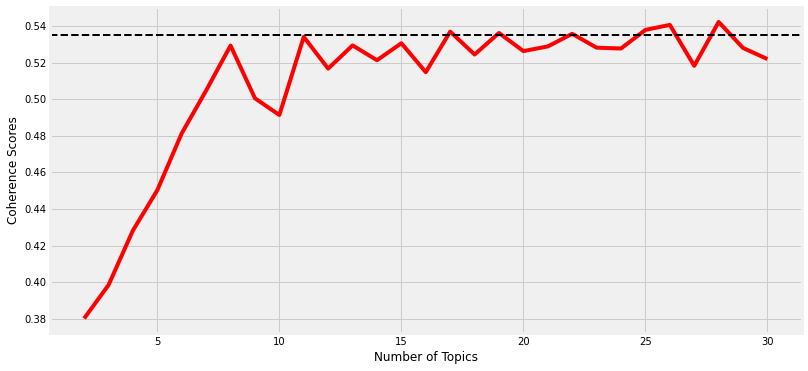

In [62]:
# plot graph showing number of topics per model and corresponding coherence scores
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2,31,1)
y_ax = coherence_scores
plt.figure(figsize=(12,6))
plt.plot(x_ax, y_ax,c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
x1 = plt.xlabel('Number of Topics')
y1 = plt.ylabel('Coherence Scores')

In [63]:
# based on graph, choose optimal number of topics as 20
# retrieve best model
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 20].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

20

In [64]:
# view all the 20 topics generated by selected best model
topics = [[(term, round(wt, 3)) 
           for term, wt in best_lda_model.show_topic(n, topn=20)] 
              for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['node', 'rule', 'structure', 'representation', 'tree', 'level', 'symbol', 'string', 'graph', 'language', 'connectionist', 'sequence', 'represented', 'part', 'role', 'activation', 'represent', 'note', 'mapping', 'grammar']

Topic #2:
['unit', 'training', 'layer', 'net', 'hidden_unit', 'pattern', 'architecture', 'task', 'trained', 'activation', 'back_propagation', 'hidden_layer', 'hidden', 'connection', 'learn', 'generalization', 'backpropagation', 'training_set', 'epoch', 'target']

Topic #3:
['neuron', 'spike', 'synaptic', 'firing', 'cell', 'synapsis', 'activity', 'response', 'threshold', 'current', 'neural', 'neuronal', 'stimulus', 'firing_rate', 'et_al', 'effect', 'constant', 'level', 'pattern', 'biological']

Topic #4:
['motion', 'direction', 'visual', 'response', 'target', 'location', 'velocity', 'stimulus', 'position', 'cue', 'light', 'task', 'sensory', 'unit', 'moving', 'eye', 'spatial', 'head', 'stage', 'sensor']

Topic #5:
['prediction', 'training', 'test', 'regressi

In [65]:
# build term topic dataframe
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns=['Term'+str(i) for i in range(1,21)], 
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

Topic 1           Topic 2      Topic 3    Topic 4  \
Term1             node              unit       neuron     motion   
Term2             rule          training        spike  direction   
Term3        structure             layer     synaptic     visual   
Term4   representation               net       firing   response   
Term5             tree       hidden_unit         cell     target   
Term6            level           pattern     synapsis   location   
Term7           symbol      architecture     activity   velocity   
Term8           string              task     response   stimulus   
Term9            graph           trained    threshold   position   
Term10        language        activation      current        cue   
Term11   connectionist  back_propagation       neural      light   
Term12        sequence      hidden_layer     neuronal       task   
Term13     represented            hidden     stimulus    sensory   
Term14            part        connection  firing_rate       unit   
Term15            role             learn        et_al     moving   
Term16      activation    generalization       effect        eye   
Term17       represent   backpropagation     constant    spatial   
Term18            note      training_set        level       head   
Term19         mapping             epoch      pattern      stage   
Term20         grammar            target   biological     sensor   

                 Topic 5         Topic 6        Topic 7          Topic 8  \
Term1         prediction          kernel   distribution             cell   
Term2           training            loss    probability         activity   
Term3               test          sample          prior         stimulus   
Term4         regression           class       gaussian         response   
Term5         experiment         machine       variable            layer   
Term6          selection    distribution        mixture          pattern   
Term7             expert      hypothesis        density              map   
Term8                rbf        training       bayesian  receptive_field   
Term9            trained         concept       estimate         cortical   
Term10            sample        estimate  approximation           cortex   
Term11      training_set           query     likelihood      orientation   
Term12             local              xi            log       connection   
Term13          estimate  generalization      component             unit   
Term14             table          target         sample           region   
Term15         technique     probability             em         contrast   
Term16            linear           bound     estimation           center   
Term17       time_series          margin      posterior           visual   
Term18  cross_validation         optimal       variance          spatial   
Term19         nonlinear  support_vector  probabilistic           effect   
Term20               fit  regularization           step            brain   

              Topic 9        Topic 10          Topic 11     Topic 12  \
Term1         theorem         circuit            vector       signal   
Term2           bound            chip            matrix       filter   
Term3       threshold         current            linear       source   
Term4   approximation          analog          solution    frequency   
Term5           class         voltage          equation      channel   
Term6           proof          neuron       convergence        noise   
Term7            size  implementation          gradient    component   
Term8      polynomial       processor        constraint    detection   
Term9      complexity          design         nonlinear        sound   
Term10     definition             bit         iteration     auditory   
Term11        bounded          device      optimization          ica   
Term12    probability          neural           optimal     response   
Term13         assume         digital                

In [66]:
# create topic term dataframe: each topic represented in a row with terms of topic
# represented as comma-separated string
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) 
                              for topic in topics], 
                         columns=['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range (1, best_lda_model.num_topics+1)])
topics_df

Terms per Topic
Topic1   node, rule, structure, representation, tree, level, symbol, string, graph, language, connectionist, sequence, represented, part, role, activation, represent, note, mapping, grammar                              
Topic2   unit, training, layer, net, hidden_unit, pattern, architecture, task, trained, activation, back_propagation, hidden_layer, hidden, connection, learn, generalization, backpropagation, training_set, epoch, target
Topic3   neuron, spike, synaptic, firing, cell, synapsis, activity, response, threshold, current, neural, neuronal, stimulus, firing_rate, et_al, effect, constant, level, pattern, biological                             
Topic4   motion, direction, visual, response, target, location, velocity, stimulus, position, cue, light, task, sensory, unit, moving, eye, spatial, head, stage, sensor                                                   
Topic5   prediction, training, test, regression, experiment, selection, expert, rbf, trained, sample, training_set, local, estimate, table, technique, linear, time_series, cross_validation, nonlinear, fit               
Topic6   kernel, loss, sample, class, machine, distribution, hypothesis, training, concept, estimate, query, xi, generalization, target, probability, bound, margin, optimal, support_vector, regularization               
Topic7   distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, likelihood, log, component, sample, em, estimation, posterior, variance, probabilistic, step           
Topic8   cell, activity, stimulus, response, layer, pattern, map, receptive_field, cortical, cortex, orientation, connection, unit, region, contrast, center, visual, spatial, effect, brain                               
Topic9   theorem, bound, threshold, approximation, class, proof, size, polynomial, complexity, definition, bounded, probability, assume, linear, constant, computation, defined, theory, property, arbitrary               
Topic10  circuit, chip, current, analog, voltage, neuron, implementation, processor, design, bit, device, neural, digital, array, parallel, synapse, computation, operation, hardware, implemented                         
Topic11  vector, matrix, linear, solution, equation, convergence, gradient, constraint, nonlinear, iteration, optimization, optimal, eq, update, minimum, energy, operator, gradient_descent, dimensional, quadratic       
Topic12  signal, filter, source, frequency, channel, noise, component, detection, sound, auditory, ica, response, phase, temporal, amplitude, correlation, eeg, separation, processing, spectral                           
Topic13  noise, equation, rate, curve, average, theory, correlation, distribution, limit, stochastic, optimal, solution, eq, line, generalization_error, teacher, asymptotic, temperature, effect, size                    
Topic14  control, position, character, trajectory, human, hand, field, subject, task, mapping, movement, forward, user, arm, target, change, force, joint, motor, feedback                                                 
Topic15  search, code, rate, bit, solution, cost, size, feature, path, block, high, table, call, application, probability, machine, run, random, program, experiment                                                       
Topic16  image, object, feature, pixel, region, view, edge, surface, local, shape, contour, scale, part, recognition, visual, scene, representation, location, vision, texture                                             
Topic17  state, dynamic, memory, pattern, recurrent, sequence, attractor, module, phase, hopfield, delay, connection, transition, capacity, fixed_point, equation, neural, stable, behavior, oscillator                    
Topic18  class, classification, classifier, feature, vector, pattern, cluster, distance, face, clustering, transformation, database, digit, training, nearest_neighbor, training_set, pca, test, template, experiment      
Topic19  word, recogniti

In [69]:
## Interpreting Topic Model Results
tm_results = best_lda_model[bow_corpus]

# get most dominant topic per research paper
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
corpus_topics[:5]

# construct master dataframe that holds base statistics
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

CalledProcessError: Command '/mnt/batch/tasks/shared/LS_root/mounts/clusters/bellepracticevm/code/Users/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/9db6d6_corpus.txt --output /tmp/9db6d6_corpus.mallet.infer --use-pipe-from /tmp/9db6d6_corpus.mallet' returned non-zero exit status 1.

In [70]:
## Dominant Topics Distribution Across Corpus
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg(
    {'Dominant Topic': {'Doc Count': np.size, '% Total Docs': np.size }})

topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].apply(
    lambda row: round((row*100) / len(papers), 2))

topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] 
                                for t in range(len(topic_stats_df))]
topic_stats_df

NameError: name 'corpus_topic_df' is not defined

In [71]:
## Dominant Topics in Specific Research Papers
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document'].isin(
    [681, 9, 392, 1622, 17, 906, 996, 503, 13, 733])])

NameError: name 'corpus_topic_df' is not defined

In [72]:
## Relevant Research Papers per Topic Based on Dominance
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: 
                                                (topic_set.sort_values(by=['Contribution %'], 
                                                                       ascending=False).iloc[0]))

NameError: name 'corpus_topic_df' is not defined

In [73]:
## Predicting Topics for New Research Papers
import glob
# papers manually downloaded from NIPS 16
# https://papers.nips.cc/book/advances-in-neural-information-processing-systems-29-2016

new_paper_files = glob.glob('test_data/nips16*.txt')
new_papers = []
for fn in new_paper_files:
    with open(fn, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
        new_papers.append(data)
print('Total New Papers', len(new_papers))

Total New Papers 4


In [74]:
# build text wrangling and feature engineering pipeline
def text_preprocessing_pipeline(documents, normalizer_fn, bigram_model):
    norm_docs = normalizer_fn(documents)
    norm_docs_bigrams = bigram_model[norm_docs]
    return norm_docs_bigrams

def bow_features_pipeline(tokenized_docs, dictionary):
    paper_bow_features = [dictionary.doc2bow(text) 
        for text in tokenized_docs]
    return paper_bow_features

norm_new_papers = text_preprocessing_pipeline(documents=new_papers, normalizer_fn=normalize_corpus, bigram_model=bigram_model)

norm_bow_features = bow_features_pipeline(tokenized_docs=norm_new_papers, dictionary=dictionary)

print(norm_new_papers[0][:30])

['cooperative', 'graphical_model', 'josip', 'djolonga', 'dept_computer', 'science', 'eth', 'zurich', 'josipd', 'inf', 'ethz', 'ch', 'stefanie', 'jegelka', 'csail', 'mit', 'stefje', 'mit_edu', 'sebastian', 'tschiatschek', 'dept_computer', 'science', 'eth', 'zurich', 'stschia', 'inf', 'ethz', 'ch', 'andreas', 'krause']


In [75]:
print(norm_bow_features[0][:30])

[(14, 1), (16, 1), (20, 1), (21, 2), (22, 2), (23, 3), (26, 1), (27, 4), (28, 1), (29, 2), (35, 1), (37, 3), (40, 7), (56, 1), (57, 2), (58, 1), (59, 5), (60, 7), (63, 1), (68, 2), (70, 4), (71, 2), (72, 1), (73, 2), (74, 5), (78, 1), (79, 1), (80, 1), (86, 1), (91, 1)]


In [76]:
# build generic fuction to extract top N topics from any research paper using trained model
def get_topic_predictions(topic_model, corpus, topn=3):
    topic_predictions = topic_model[corpus]
    best_topics = [[(topic, round(wt, 3)) 
                        for topic, wt in sorted(topic_predictions[i], 
                                                key=lambda row: -row[1])[:topn]] 
                            for i in range(len(topic_predictions))]
    return best_topics
# putting the function in action
topic_preds = get_topic_predictions(topic_model=best_lda_model, corpus=norm_bow_features, topn=2)
topic_preds

CalledProcessError: Command '/mnt/batch/tasks/shared/LS_root/mounts/clusters/bellepracticevm/code/Users/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/9db6d6_corpus.txt --output /tmp/9db6d6_corpus.mallet.infer --use-pipe-from /tmp/9db6d6_corpus.mallet' returned non-zero exit status 1.

In [77]:
# review results for each paper
results_df = pd.DataFrame()
results_df['Papers'] = range(1, len(new_papers)+1)
results_df['Dominant Topics'] = [[topic_num+1 for topic_num, wt in item] for item in topic_preds]
res = results_df.set_index(['Papers'])['Dominant Topics'].apply(
    pd.Series).stack().reset_index(level=1, drop=True)
results_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results_df['Contribution %'] = [topic_wt for topic_list in 
                                        [[round(wt*100, 2) 
                                              for topic_num, wt in item] 
                                                 for item in topic_preds] 
                                    for topic_wt in topic_list]

results_df['Topic Desc'] = [topics_df.iloc[t-1]['Terms per Topic'] for t in results_df['Dominant Topics'].values]
results_df['Paper Desc'] = [new_papers[i-1][:200] for i in results_df.index.values]

NameError: name 'topic_preds' is not defined

In [78]:
pd.set_option('display.max_colwidth', 300)
results_df

Papers
0       1
1       2
2       3
3       4

## Topic Models with Scikit-Learn

In [79]:
## Text Representation with Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=20, max_df=0.6, ngram_range=(1,2), token_pattern=None, 
                     tokenizer=lambda doc: doc, preprocessor=lambda doc: doc)
cv_features = cv.fit_transform(norm_papers)
cv_features.shape

# validating vocabulary size
vocabulary = np.array(cv.get_feature_names())
print('Total Vocabulary Size', len(vocabulary))

Total Vocabulary Size 14408


In [80]:
%%time
## Latent Semantic Indexing
from sklearn.decomposition import TruncatedSVD

TOTAL_TOPICS=20
lsi_model = TruncatedSVD(n_components=TOTAL_TOPICS, n_iter=500, random_state=42)
document_topics = lsi_model.fit_transform(cv_features)

CPU times: user 1min 43s, sys: 1min 55s, total: 3min 38s
Wall time: 55 s


In [81]:
topic_terms = lsi_model.components_
topic_terms.shape

(20, 14408)

In [82]:
# reuse previously implemented code to display topics and terms
top_terms = 20
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterm_weights = np.array([topic_terms[row, columns] 
                                  for row, columns in list(
                                      zip(np.arange(TOTAL_TOPICS), topic_key_term_idxs))])
topic_keyterms = vocabulary[topic_key_term_idxs]
topic_keyterms_weights = list(zip(topic_keyterms, topic_keyterm_weights))

for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    terms, weights = topic_keyterms_weights[n]
    term_weights = sorted([(t,w) for t, w in zip(terms, weights)],
        key = lambda row: -abs(row[1]))
    for term, wt in term_weights:
        if wt >= 0:
            d1.append((term, round(wt,3)))
        else:
            d2.append((term, round(wt, 3)))
        
    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()


Topic #1:
Direction 1: [('state', 0.221), ('neuron', 0.169), ('image', 0.138), ('cell', 0.13), ('layer', 0.13), ('feature', 0.127), ('probability', 0.121), ('hidden', 0.114), ('distribution', 0.105), ('rate', 0.098), ('signal', 0.095), ('task', 0.093), ('class', 0.092), ('noise', 0.09), ('net', 0.089), ('recognition', 0.089), ('representation', 0.088), ('field', 0.082), ('rule', 0.082), ('step', 0.08)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('cell', 0.417), ('neuron', 0.39), ('response', 0.175), ('stimulus', 0.155), ('visual', 0.131), ('spike', 0.13), ('firing', 0.117), ('synaptic', 0.11), ('activity', 0.104), ('cortex', 0.097), ('field', 0.085), ('frequency', 0.085), ('direction', 0.082), ('circuit', 0.082), ('motion', 0.082)]
--------------------------------------------------
Direction 2: [('state', -0.289), ('probability', -0.109), ('hidden', -0.098), ('class', -0.091), ('policy',

In [83]:
# extract key topics for specific research papers
dt_df = pd.DataFrame(np.round(document_topics,3), 
            columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])

document_numbers = [13, 250, 500]

for document_number in document_numbers:
    top_topics = list(dt_df.columns[np.argsort(-np.absolute(dt_df.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T1', 'T8', 'T3']
Paper Summary:
137 
On the 
Power of Neural Networks for 
Solving Hard Problems 
Jehoshua Bruck 
Joseph W. Goodman 
Information Systems Laboratory 
Department of Electrical Engineering 
Stanford University 
Stanford, CA 94305 
Abstract 
This paper deals with a neural network model in which each neuron 
performs a threshold logic function. An important property of the model 
is that it always converges to a stable state when operating in a serial 
mode [2,5]. This property is the basis of the potential applicat

Document #250:
Dominant Topics (top 3): ['T1', 'T13', 'T5']
Paper Summary:
542 Kassebaum, Tenorio and Schaefers 
The Cocktail Party Problem: 
Speech/Data Signal Separation Comparison 
between Backpropagation and SONN 
John Kassebaum 
jakec.ecn.purdue.edu 
Manoel Fernando Tenorio 
tenorioee.ecn.purdue.edu 
Chrlstoph Schaefers 
Parallel Distributed Structures Laboratory 
School of Electrical Engineering 
Purdue University

In [84]:
%%time
## Latent Dirichlet Allocation
from sklearn.decomposition import LatentDirichletAllocation

#lda_model = LatentDirichletAllocation(n_components=TOTAL_TOPICS, max_iter=500, 
                                      max_doc_update_iter=50, learning_method='online', 
                                      batch_size=1740, learning_offset=50., 
                                      random_state=42, n_jobs=16)
#document_topics = lda_model.fit_transform(cv_features)

CPU times: user 53.2 s, sys: 11 s, total: 1min 4s
Wall time: 51min 21s


In [85]:
import pickle

# location of file
filename = path_to_users + '/LearningCode/NLP_Learning/sklearn_lda_models.sav'

# save model for later use
# pickle.dump(lda_model, open(filename, 'wb'))

# load model and scores
lda_model = pickle.load(open(filename, 'rb'))

In [87]:
# obtain topic-term matrix
# build dataframe from it to showcase topics and terms
topic_terms = lda_model.components_
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics, columns=['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

Terms per Topic
Topic1   neuron, circuit, chip, analog, current, signal, voltage, channel, noise, bit, vlsi, implementation, pulse, processor, synapse, fig, parallel, design, connection, gain                                      
Topic2   image, feature, state, structure, layer, neuron, distribution, local, cell, motion, matrix, recognition, object, node, net, sequence, size, gaussian, line, hidden                                          
Topic3   motor, sound, auditory, template, frequency, acoustic, syllable, production, song, harmonic, nucleus, control, spectrogram, phase, feedback, motor learning, khz, representation, template matching, hearing
Topic4   cell, neuron, response, visual, stimulus, activity, spike, field, motion, synaptic, direction, cortex, firing, signal, orientation, spatial, eye, map, rate, fig                                            
Topic5   image, feature, recognition, layer, hidden, task, speech, object, representation, trained, test, classification, classifier, net, class, architecture, level, experiment, hidden unit, rule                 
Topic6   state, dynamic, rule, matrix, recurrent, equation, gradient, hidden, signal, sequence, fixed, source, component, attractor, node, structure, net, fixed point, step, representation                         
Topic7   sequence, chain, region, structure, protein, prediction, hmms, site, receptor, gene, class, human, positive, mouse, length, window, sheet, cell, domain, secondary                                          
Topic8   memory, word, context, similarity, item, recall, phoneme, probability, short, list, association, representation, activation, state, address, short term, phone, serial, store, term memory                  
Topic9   activation, winner, take, behavior, competitive, winner take, connection, active, self, activation function, wta, competition, level, activity, role, binding, food, sensor, net, insect                    
Topic10  state, cell, distribution, neuron, probability, control, response, layer, signal, rate, architecture, task, test, random, hidden, image, change, fig, generalization, field                                 
Topic11  field, solution, energy, cluster, constraint, graph, distance, optimization, capacity, clustering, minimum, temperature, matching, mean field, annealing, equation, local, cost, line, objective            
Topic12  feature, image, distribution, neuron, hidden, state, class, probability, layer, node, equation, size, line, prediction, matrix, rate, signal, et, noise, recognition                                        
Topic13  image, state, cell, object, rule, layer, step, et al, distribution, neuron, signal, field, visual, dynamic, feature, probability, ii, current, solution, et                                                 
Topic14  neuron, map, cell, state, rate, hidden, field, equation, probability, node, signal, dynamic, representation, layer, et al, sequence, test, noise, recognition, prediction                                   
Topic15  distribution, probability, variable, gaussian, class, approximation, estimate, sample, density, noise, mixture, log, likelihood, matrix, optimal, prior, generalization, variance, xi, prediction           
Topic16  state, neuron, rule, layer, probability, rate, image, memory, distribution, equation, signal, solution, response, class, theory, et, step, feature, variable, high                                          
Topic17  state, feature, probability, image, layer, cell, field, neuron, task, rate, recognition, control, dynamic, rule, variable, distribution, equation, representation, net, class                               
Topic18  state, control, action, policy, reinforcement, task, optimal, step, dynamic, controller, trajectory, robot, reinforcement learning, environment, reward, path, goal, decision, value function, arm          
Topic19  state, control, feature, probability, hidden, architecture, neuron, task, rate, level, estimate, et, net, local, distributi

In [94]:
# view research papers having max contribution of each of the 20 topics
dt_df = pd.DataFrame(document_topics, 
                     columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 200)

max_contrib_topics = dt_df.max(axis=0)
dominant_topics = max_contrib_topics.index
contrib_perc = max_contrib_topics.values
document_numbers = [dt_df[dt_df[t] == max_contrib_topics.loc[t]].index[0]
                        for t in dominant_topics]
documents = [papers[i] for i in document_numbers]

# display using dataframe
results_df = pd.DataFrame({'Dominant Topic': dominant_topics, 
                           'Contribution %': contrib_perc,
                           'Paper Num': document_numbers, 
                           'Topic': topics_df['Terms per Topic'],
                           'Paper Name': documents}
                         )
results_df

Dominant Topic  Contribution %  Paper Num  \
Topic1              T1         0.99935         58   
Topic2              T2         0.00033        181   
Topic3              T3         0.71411        182   
Topic4              T4         0.99945       1005   
Topic5              T5         0.99783        235   
Topic6              T6         0.96184       1070   
Topic7              T7         0.99956        236   
Topic8              T8         0.96245        850   
Topic9              T9         0.99938        470   
Topic10            T10         0.00033        181   
Topic11            T11         0.97772       1341   
Topic12            T12         0.00033        181   
Topic13            T13         0.00033        181   
Topic14            T14         0.00033        181   
Topic15            T15         0.99942       1487   
Topic16            T16         0.00033        181   
Topic17            T17         0.00033        181   
Topic18            T18         0.99953        891   
Topic19            T19         0.00033        181   
Topic20            T20         0.71047        270   

                                                                                                                                                                                                           Topic  \
Topic1                                    neuron, circuit, chip, analog, current, signal, voltage, channel, noise, bit, vlsi, implementation, pulse, processor, synapse, fig, parallel, design, connection, gain   
Topic2                                        image, feature, state, structure, layer, neuron, distribution, local, cell, motion, matrix, recognition, object, node, net, sequence, size, gaussian, line, hidden   
Topic3   motor, sound, auditory, template, frequency, acoustic, syllable, production, song, harmonic, nucleus, control, spectrogram, phase, feedback, motor learning, khz, representation, template matching,...   
Topic4                                          cell, neuron, response, visual, stimulus, activity, spike, field, motion, synaptic, direction, cortex, firing, signal, orientation, spatial, eye, map, rate, fig   
Topic5               image, feature, recognition, layer, hidden, task, speech, object, representation, trained, test, classification, classifier, net, class, architecture, level, experiment, hidden unit, rule   
Topic6                       state, dynamic, rule, matrix, recurrent, equation, gradient, hidden, signal, sequence, fixed, source, component, attractor, node, structure, net, fixed point, step, representation   
Topic7                                        sequence, chain, region, structure, protein, prediction, hmms, site, receptor, gene, class, human, positive, mouse, length, window, sheet, cell, domain, secondary   
Topic8                memory, word, context, similarity, item, recall, phoneme, probability, short, list, association, representation, activation, state, address, short term, phone, serial, store, term memory   
Topic9                  activation, winner, take, behavior, competitive, winner take, connection, active, self, activation function, wta, competition, level, activity, role, binding, food, sensor, net, insect   
Topic10                              state, cell, distribution, neuron, probability, control, response, layer, signal, rate, architecture, task, test, random, hidden, image, change, fig, generalization, field   
Topic11         field, solution, energy, cluster, constraint, graph, distance, optimization, capacity, clustering, minimum, temperature, matching, mean field, annealing, equation, local, cost, line, objective   
Topic12                                     feature, image, distribution, neuron, hidden, state, class, probability, layer, node, equation, size, line, prediction, matrix, rate, signal, et, noise, recognition   
Topic13                                              image, state, cell, object, rule, layer, step, et al, distribution, neuron, signal, f

In [95]:
%%time
## Non-Negative Matrix Factorization
from sklearn.decomposition import NMF

nmf_model = NMF(n_components=TOTAL_TOPICS, solver='cd', max_iter=500, 
                random_state=42, alpha=.1, l1_ratio=.85)
document_topics = nmf_model.fit_transform(cv_features)

CPU times: user 16 s, sys: 1.79 s, total: 17.8 s
Wall time: 15.4 s


In [96]:
# view generated topics
topic_terms = nmf_model.components_
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics, columns=['Terms per Topic'],
                            index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

Terms per Topic
Topic1   bound, class, threshold, theorem, let, probability, size, dimension, vc, sample, polynomial, distribution, proof, net, complexity, approximation, theory, loss, xi, vc dimension                                               
Topic2   neuron, synaptic, connection, potential, dynamic, activity, synapsis, excitatory, layer, simulation, synapse, inhibitory, delay, biological, state, equation, et, et al, activation, fig                                       
Topic3   state, action, policy, step, reinforcement, optimal, reinforcement learning, transition, probability, reward, value function, dynamic, markov, machine, task, agent, finite, iteration, sequence, decision                     
Topic4   image, face, pixel, recognition, local, scale, texture, digit, distance, filter, scene, vision, edge, facial, pca, representation, region, visual, surface, database                                                           
Topic5   hidden, layer, net, hidden unit, task, hidden layer, architecture, back, trained, propagation, connection, back propagation, activation, representation, output unit, neural net, internal, generalization, learn, training set
Topic6   cell, firing, head, response, direction, rat, layer, cortex, activity, ii, spatial, synaptic, inhibitory, synapsis, simulation, cue, region, property, complex, lot                                                            
Topic7   word, recognition, speech, context, hmm, speaker, speech recognition, character, phoneme, probability, frame, sequence, rate, level, test, acoustic, experiment, letter, segmentation, state                                   
Topic8   signal, noise, source, filter, frequency, component, speech, channel, sound, independent, separation, ica, phase, auditory, matrix, eeg, blind, delay, acoustic, spectrum                                                      
Topic9   control, controller, trajectory, motor, movement, task, dynamic, forward, feedback, arm, inverse, position, robot, architecture, hand, force, target, change, command, adaptive                                                
Topic10  circuit, chip, current, analog, voltage, vlsi, transistor, gate, pulse, threshold, design, implementation, synapse, bit, digital, device, analog vlsi, cmos, pp, line                                                          
Topic11  spike, rate, firing, stimulus, train, spike train, firing rate, response, frequency, neuron, potential, current, fig, synaptic, change, timing, probability, correlation, temporal, distribution                               
Topic12  rule, learning rule, knowledge, category, condition, domain, symbolic, fuzzy, change, extraction, class, table, step, interval, expert, learn, language, activation, trained, learned                                          
Topic13  node, tree, decision, level, graph, structure, decision tree, leaf, path, layer, variable, field, parent, routing, split, child, propagation, architecture, activation, probability                                            
Topic14  feature, map, task, search, classification, experiment, representation, part, target, feature map, attention, orientation, feature vector, location, feature space, dimensional, region, cluster, kernel, extra                
Topic15  classifier, class, classification, decision, rbf, region, rate, test, error rate, center, nearest, neighbor, nearest neighbor, training set, boundary, layer, gaussian, trained, sample, mixture                               
Topic16  distribution, gaussian, probability, mixture, variable, density, likelihood, prior, bayesian, component, posterior, em, log, estimate, sample, approximation, estimation, conditional, structure, maximum                      
Topic17  field, visual, motion, stimulus, response, direction, orientation, eye, receptive, receptive field, cortex, map, cortical, velocity, spatial, activity, position, center, location, target                                     
Topic18  object, view, 

In [98]:
# determine dominance of topics in research papers by absolute scores
pd.options.display.float_format = '{:,.3f}'.format
dt_df = pd.DataFrame(document_topics, columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
dt_df.head(10)

T1    T2    T3    T4    T5    T6    T7    T8    T9   T10   T11   T12  \
0 0.521 0.988 0.059 0.002 0.000 0.000 0.000 0.000 0.020 0.099 0.000 0.104   
1 0.000 1.322 0.261 0.000 0.300 0.000 0.000 0.970 0.181 0.930 0.000 0.524   
2 0.130 0.595 0.454 0.008 0.167 0.035 0.000 0.123 0.105 0.022 0.000 0.234   
3 0.065 1.525 0.000 0.046 0.000 0.000 0.309 0.620 0.228 0.168 0.000 0.964   
4 1.259 0.271 0.355 0.000 0.446 0.000 0.000 0.000 0.000 1.396 0.000 0.325   
5 0.119 0.133 0.000 0.000 0.595 0.008 0.016 0.000 0.010 0.000 0.000 0.068   
6 0.000 0.000 0.000 0.007 0.007 1.184 0.015 0.000 0.000 0.000 0.088 0.072   
7 0.048 0.093 0.175 0.000 0.675 0.000 0.000 0.000 0.000 0.036 0.042 0.685   
8 0.000 0.969 0.177 0.000 0.000 1.037 0.000 0.000 0.034 0.949 3.047 0.000   
9 0.185 1.301 0.000 0.000 0.000 0.000 0.000 0.288 0.000 0.000 3.197 0.118   

    T13   T14   T15   T16   T17   T18   T19   T20  
0 0.018 0.044 0.000 0.169 0.000 0.047 0.000 0.000  
1 0.087 0.223 0.035 0.199 0.000 0.021 0.230 0.557  
2 0.005 0.000 0.000 0.000 0.000 0.103 0.177 0.717  
3 0.100 0.000 0.074 0.000 0.000 0.000 0.146 0.303  
4 0.003 0.000 0.000 0.000 0.000 0.000 1.036 0.000  
5 0.791 0.006 0.038 0.246 0.004 0.025 0.000 0.222  
6 0.032 0.786 0.182 0.000 1.899 0.000 0.000 0.477  
7 0.000 0.000 0.000 0.000 0.000 0.000 0.093 0.777  
8 0.075 0.000 0.000 0.000 0.000 0.052 0.038 0.000  
9 0.000 0.499 0.524 0.093 0.000 0.054 0.000 0.000

In [99]:
# determine most relevant paper for each topic based on topic dominance scores
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 200)

max_score_topics = dt_df.max(axis=0)
dominant_topics = max_score_topics.index
term_score = max_score_topics.values
document_numbers = [dt_df[dt_df[t] == max_score_topics.loc[t]].index[0]
                        for t in dominant_topics]
documents = [papers[i] for i in document_numbers]
results_df = pd.DataFrame({'Dominant Topic': dominant_topics, 'Max Score': term_score,
                            'Paper Num': document_numbers, 'Topic': topics_df['Terms per Topic'],
                            'Paper Name': documents})
results_df

Dominant Topic  Max Score  Paper Num  \
Topic1              T1    1.98178       1154   
Topic2              T2    3.58244        323   
Topic3              T3    5.88608       1279   
Topic4              T4    3.91592       1714   
Topic5              T5    2.99090        734   
Topic6              T6    7.47698         34   
Topic7              T7    4.91490       1301   
Topic8              T8    3.78582        213   
Topic9              T9    4.86516        971   
Topic10            T10    2.89098       1717   
Topic11            T11    6.17181        994   
Topic12            T12    6.07346        906   
Topic13            T13    3.58858       1632   
Topic14            T14    4.06160        217   
Topic15            T15    5.20976        205   
Topic16            T16    2.77950       1054   
Topic17            T17    3.35637        618   
Topic18            T18    5.52967        484   
Topic19            T19    6.13310         75   
Topic20            T20    2.52369         63   

                                                                                                                                                                                                           Topic  \
Topic1                          bound, class, threshold, theorem, let, probability, size, dimension, vc, sample, polynomial, distribution, proof, net, complexity, approximation, theory, loss, xi, vc dimension   
Topic2                  neuron, synaptic, connection, potential, dynamic, activity, synapsis, excitatory, layer, simulation, synapse, inhibitory, delay, biological, state, equation, et, et al, activation, fig   
Topic3   state, action, policy, step, reinforcement, optimal, reinforcement learning, transition, probability, reward, value function, dynamic, markov, machine, task, agent, finite, iteration, sequence, de...   
Topic4                                      image, face, pixel, recognition, local, scale, texture, digit, distance, filter, scene, vision, edge, facial, pca, representation, region, visual, surface, database   
Topic5   hidden, layer, net, hidden unit, task, hidden layer, architecture, back, trained, propagation, connection, back propagation, activation, representation, output unit, neural net, internal, generali...   
Topic6                                       cell, firing, head, response, direction, rat, layer, cortex, activity, ii, spatial, synaptic, inhibitory, synapsis, simulation, cue, region, property, complex, lot   
Topic7              word, recognition, speech, context, hmm, speaker, speech recognition, character, phoneme, probability, frame, sequence, rate, level, test, acoustic, experiment, letter, segmentation, state   
Topic8                                 signal, noise, source, filter, frequency, component, speech, channel, sound, independent, separation, ica, phase, auditory, matrix, eeg, blind, delay, acoustic, spectrum   
Topic9                           control, controller, trajectory, motor, movement, task, dynamic, forward, feedback, arm, inverse, position, robot, architecture, hand, force, target, change, command, adaptive   
Topic10                                    circuit, chip, current, analog, voltage, vlsi, transistor, gate, pulse, threshold, design, implementation, synapse, bit, digital, device, analog vlsi, cmos, pp, line   
Topic11         spike, rate, firing, stimulus, train, spike train, firing rate, response, frequency, neuron, potential, current, fig, synaptic, change, timing, probability, correlation, temporal, distribution   
Topic12                    rule, learning rule, knowledge, category, condition, domain, symbolic, fuzzy, change, extraction, class, table, step, interval, expert, learn, language, activation, trained, learned   
Topic13                      node, tree, decision, level, graph, structure, decision tree, leaf, path, layer, variable, field, parent, routing, split, child, propagation, architecture, activation, probability   
Topic14  feature, map, task, se

In [101]:
## Predicting Topics for New Research Papers
import glob
# papers manually downloaded from NIPS 16
# https://papers.nips.cc/book/advances-in-neural-information-processing-systems-29-2016

new_paper_files = glob.glob('test_data/nips16*.txt')
new_papers = []
for fn in new_paper_files:
    with open(fn, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
        new_papers.append(data)

print('Total New Papers:', len(new_papers))

Total New Papers: 4


In [102]:
# preprocess documents and extract features
norm_new_papers = normalize_corpus(new_papers)
cv_new_features = cv.transform(norm_new_papers)
cv_new_features.shape

(4, 14408)

In [103]:
# use NMF topic model to predict topics for new research papers 
topic_predictions = nmf_model.transform(cv_new_features)
best_topics = [[(topic, round(sc, 3))
                   for topic, sc in sorted(enumerate(topic_predictions[i]), 
                                           key=lambda row: -row[1])[:2]]
                      for i in range(len(topic_predictions))]
best_topics

[[(0, 1.28), (15, 0.799)],
 [(2, 4.186), (0, 1.043)],
 [(3, 2.125), (1, 1.341)],
 [(3, 3.06), (6, 2.181)]]

In [104]:
# view results
results_df = pd.DataFrame()
results_df['Papers'] = range(1, len(new_papers)+1)
results_df['Dominant Topics'] = [[topic_num+1 for topic_num, sc in item]
                                    for item in best_topics]
res = results_df.set_index(['Papers'])['Dominant Topics'].apply(pd.Series).stack().reset_index(level=1, drop=True)
results_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results_df['Topic Score'] = [topic_sc for topic_list in [[round(sc*100, 2)
                                                             for topic_num, sc in item]
                                                                for item in best_topics]
                                         for topic_sc in topic_list]
results_df['Topic Desc'] = [topics_df.iloc[t-1]['Terms per Topic']
                           for t in results_df['Dominant Topics'].values]
results_df['Paper Desc'] = [new_papers[i-1][:200] for i in results_df.index.values]
results_df

Dominant Topics  Topic Score  \
Papers                                 
1                     1    128.00000   
1                    16     79.90000   
2                     3    418.60000   
2                     1    104.30000   
3                     4    212.50000   
3                     2    134.10000   
4                     4    306.00000   
4                     7    218.10000   

                                                                                                                                                                                                     Topic Desc  \
Papers                                                                                                                                                                                                            
1                              bound, class, threshold, theorem, let, probability, size, dimension, vc, sample, polynomial, distribution, proof, net, complexity, approximation, theory, loss, xi, vc dimension   
1       distribution, gaussian, probability, mixture, variable, density, likelihood, prior, bayesian, component, posterior, em, log, estimate, sample, approximation, estimation, conditional, structure, ma...   
2       state, action, policy, step, reinforcement, optimal, reinforcement learning, transition, probability, reward, value function, dynamic, markov, machine, task, agent, finite, iteration, sequence, de...   
2                              bound, class, threshold, theorem, let, probability, size, dimension, vc, sample, polynomial, distribution, proof, net, complexity, approximation, theory, loss, xi, vc dimension   
3                                          image, face, pixel, recognition, local, scale, texture, digit, distance, filter, scene, vision, edge, facial, pca, representation, region, visual, surface, database   
3                      neuron, synaptic, connection, potential, dynamic, activity, synapsis, excitatory, layer, simulation, synapse, inhibitory, delay, biological, state, equation, et, et al, activation, fig   
4                                          image, face, pixel, recognition, local, scale, texture, digit, distance, filter, scene, vision, edge, facial, pca, representation, region, visual, surface, database   
4                  word, recognition, speech, context, hmm, speaker, speech recognition, character, phoneme, probability, frame, sequence, rate, level, test, acoustic, experiment, letter, segmentation, state   

                                                                                                                                                                                                     Paper Desc  
Papers                                                                                                                                                                                                           
1       Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer S...  
1       Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer S...  
2       PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York,...  
2       PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York,...  
3       Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\...  
3       Automated scalable

In [ ]:
## Visualizing Topic Models
#import pyLDAvis
#import pyLDAvis.sklearn
#import dill
#import warnings

#warnings.filterwarnings('ignore')
#pyLDAvis.enable_notebook()

#pyLDAvis.sklearn.prepare(nmf_model, cv_features, cv, mds='mmds')

## Automated Document Summarization

In [115]:
DOCUMENT = """
The Elder Scrolls V: Skyrim is an action role-playing video game developed by Bethesda Game Studios 
and published by Bethesda Softworks. It is the fifth main installment in The Elder Scrolls series, 
following The Elder Scrolls IV: Oblivion.
The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, 
a dragon who is prophesied to destroy the world. The game is set 200 years after the events of Oblivion 
and takes place in the fictional province of Skyrim. Over the course of the game, the player completes 
quests and develops the character by improving skills. The game continues the open-world tradition of 
its predecessors by allowing the player to travel anywhere in the game world at any time, and to ignore 
or postpone the main storyline indefinitely.
The team opted for a unique and more diverse open world than Oblivion's Imperial Province of Cyrodiil, 
which game director and executive producer Todd Howard considered less interesting by comparison. 
The game was released to critical acclaim, with reviewers particularly mentioning the character advancement 
and setting, and is considered to be one of the greatest video games of all time.

The Elder Scrolls V: Skyrim is an action role-playing game, playable from either a first or 
third-person perspective. The player may freely roam over the land of Skyrim which is an open world 
environment consisting of wilderness expanses, dungeons, cities, towns, fortresses, and villages. 
Players may navigate the game world more quickly by riding horses or by utilizing a fast-travel system 
which allows them to warp to previously discovered locations. The game's main quest can be completed or 
ignored at the player's preference after the first stage of the quest is finished. However, some quests 
rely on the main storyline being at least partially completed. Non-player characters (NPCs) populate the 
world and can be interacted with in a number of ways: the player may engage them in conversation, 
marry an eligible NPC, kill them or engage in a nonlethal "brawl". The player may 
choose to join factions which are organized groups of NPCs — for example, the Dark Brotherhood, a band 
of assassins. Each of the factions has an associated quest path to progress through. Each city and town 
in the game world has jobs that the player can engage in, such as farming.

Players have the option to develop their character. At the beginning of the game, players create 
their character by selecting their sex and choosing between one of several races including humans, 
orcs, elves, and anthropomorphic cat or lizard-like creatures and then customizing their character's 
appearance. Over the course of the game, players improve their character's skills which are numerical 
representations of their ability in certain areas. There are eighteen skills divided evenly among the 
three schools of combat, magic, and stealth. When players have trained skills enough to meet the 
required experience, their character levels up. Health is depleted primarily when the player 
takes damage and the loss of all health results in death. Magicka is depleted by the use of spells, 
certain poisons and by being struck by lightning-based attacks. Stamina determines the player's 
effectiveness in combat and is depleted by sprinting, performing heavy "power attacks" 
and being struck by frost-based attacks. Skyrim is the first entry in The Elder Scrolls to 
include dragons in the game's wilderness. Like other creatures, dragons are generated randomly in 
the world and will engage in combat with NPCs, creatures and the player. Some dragons may attack 
cities and towns when in their proximity. The player character can absorb the souls of dragons 
in order to use powerful spells called "dragon shouts" or "Thu'um". A regeneration 
period limits the player's use of shouts in gameplay.

Skyrim is set around 200 years after the events of The Elder Scrolls IV: Oblivion, although it is 
not a direct sequel. The game takes place in Skyrim, a province of the Empire on the continent of 
Tamriel, amid a civil war between two factions: the Stormcloaks, led by Ulfric Stormcloak, and the 
Imperial Legion, led by General Tullius. The player character is a Dragonborn, a mortal born with 
the soul and power of a dragon. Alduin, a large black dragon who returns to the land after being 
lost in time, serves as the game's primary antagonist. Alduin is the first dragon created by Akatosh, 
one of the series' gods, and is prophesied to destroy and consume the world.
"""

In [116]:
# preprocessing
import re

DOCUMENT = re.sub(r'\n|\r', ' ', DOCUMENT)
DOCUMENT = re.sub(r' +', ' ', DOCUMENT)
DOCUMENT = DOCUMENT.strip()

In [117]:
# implement document summarization using Gensim's summarization module
from gensim.summarization import summarize

print(summarize(DOCUMENT, ratio=0.2, split=False))

The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, a dragon who is prophesied to destroy the world.
Over the course of the game, the player completes quests and develops the character by improving skills.
The game continues the open-world tradition of its predecessors by allowing the player to travel anywhere in the game world at any time, and to ignore or postpone the main storyline indefinitely.
The player may freely roam over the land of Skyrim which is an open world environment consisting of wilderness expanses, dungeons, cities, towns, fortresses, and villages.
Each city and town in the game world has jobs that the player can engage in, such as farming.
Over the course of the game, players improve their character's skills which are numerical representations of their ability in certain areas.
Like other creatures, dragons are generated randomly in the world and will engage in combat with NPCs, creatures and the player.


In [118]:
# limit summarization based on word count instead of proportions
print(summarize(DOCUMENT, word_count=75, split=False))

The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, a dragon who is prophesied to destroy the world.
Over the course of the game, the player completes quests and develops the character by improving skills.
The player may freely roam over the land of Skyrim which is an open world environment consisting of wilderness expanses, dungeons, cities, towns, fortresses, and villages.


In [119]:
## Text Wrangling
import nltk
import numpy as np
import re

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalized_corpus = np.vectorize(normalize_document)

# get sentences in the document
sentences = nltk.sent_tokenize(DOCUMENT)

# normalize each sentence in the document
norm_sentences = normalize_corpus(sentences)
norm_sentences[:3]

[['elder',
  'scroll',
  'skyrim',
  'action',
  'role',
  'playing',
  'video',
  'game',
  'developed',
  'bethesda',
  'game',
  'studio',
  'published',
  'bethesda',
  'softworks'],
 ['fifth',
  'main',
  'installment',
  'elder',
  'scroll',
  'series',
  'following',
  'elder',
  'scroll',
  'iv',
  'oblivion'],
 ['game',
  'main',
  'story',
  'revolves',
  'around',
  'player',
  'character',
  'quest',
  'defeat',
  'alduin',
  'world',
  'eater',
  'dragon',
  'prophesied',
  'destroy',
  'world']]

In [114]:
## Text Representation with Feature Engineering
# vectorize normalized sentences using TF-IDF feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
dt_matrix = tv.fit_transform(norm_sentences)
dt_matrix = dt_matrix.toarray()

vocab = tv.get_feature_names()
td_matrix = dt_matrix.T
print(td_matrix.shape)
pd.DataFrame(np.round(td_matrix,2), index=vocab).head(10)

AttributeError: 'list' object has no attribute 'lower'

In [120]:
## Latent Semantic Analysis
# select number of sentences n that summary will contain
# perform low-rank SVD
num_sentences = 8
num_topics = 3

u, s, vt = low_rank_svd(td_matrix, singular_count=num_topics)
print(u.shape, s.shape, vt.shape)
term_topic_mat, singular_values, topic_document_mat = u, s, vt

(7756, 3) (3,) (3, 1740)


In [121]:
# remore singular values below threshold
sv_threshold = 0.5
min_sigma_value = max(singular_values) * sv_threshold
singular_values[singular_values < min_sigma_value] = 0

In [122]:
# compute sentence sailency scores for each sentence (document) in game description
salience_scores = np.sqrt(np.dot(np.square(singular_values), 
                                 np.square(topic_document_mat)))
salience_scores

array([22.171356, 53.64662 , 26.859047, ..., 37.340725, 29.907743,
       40.36577 ], dtype=float32)

In [124]:
# select top sentences based on saliency score
# display summary of game description
top_sentence_indices = (-salience_scores).argsort()[:num_sentences]
top_sentence_indices.sort()
print('\n'.join(np.array(sentences)[top_sentence_indices]))

IndexError: index 187 is out of bounds for axis 0 with size 35

In [125]:
## TextRank
# reuse document-term feature matrix from LSA
# compute document similarity matrix
similarity_matrix = np.matmul(dt_matrix, dt_matrix.T)
print(similarity_matrix.shape)
np.round(similarity_matrix, 3)

NameError: name 'dt_matrix' is not defined

In [ ]:
# plot connected graph among all sentences from document
import networkx
# build similarity graph
similarity_graph = networkx.from_numpy_array(similarity_matrix)
similarity_graph

In [ ]:
# view the similarity graph
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
networkx.draw_networkx(similarity_graph, node_color='lime')

In [ ]:
# compute pagerank scores for all the sentences
scores = networkx.pagerank(similarity_graph)
ranked_sentences = sorted(((score, index) for index, score in scores.items()), reverse=True)
ranked_sentences[:10]

In [ ]:
# get the top sentence indices for our summary
top_sentence_indices = [ranked_sentences[index][1]
                           for index in range(num_sentences)]
top_sentence_indices.sort()

# construct the document summary
print('\n'.join(np.array(sentences)[top_sentence_indices]))